# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [26]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [5]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
print(df_offers)

    offer_id   campaign            varietal  min_qty  discount        origin  \
0          1    January              Malbec       72        56        France   
1          2    January          Pinot Noir       72        17        France   
2          3   February           Espumante      144        32        Oregon   
3          4   February           Champagne       72        48        France   
4          5   February  Cabernet Sauvignon      144        44   New Zealand   
5          6      March            Prosecco      144        86         Chile   
6          7      March            Prosecco        6        40     Australia   
7          8      March           Espumante        6        45  South Africa   
8          9      April          Chardonnay      144        57         Chile   
9         10      April            Prosecco       72        52    California   
10        11        May           Champagne       72        85        France   
11        12        May            Prose

We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [6]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
print(df_transactions)

    customer_name  offer_id  n
0           Smith         2  1
1           Smith        24  1
2         Johnson        17  1
3         Johnson        24  1
4         Johnson        26  1
5        Williams        18  1
6        Williams        22  1
7        Williams        31  1
8           Brown         7  1
9           Brown        29  1
10          Brown        30  1
11          Jones         8  1
12         Miller         6  1
13         Miller        10  1
14         Miller        14  1
15         Miller        15  1
16         Miller        22  1
17         Miller        23  1
18         Miller        31  1
19          Davis        12  1
20          Davis        22  1
21          Davis        25  1
22         Garcia        14  1
23         Garcia        15  1
24      Rodriguez         2  1
25      Rodriguez        26  1
26         Wilson         8  1
27         Wilson        30  1
28       Martinez        12  1
29       Martinez        25  1
..            ...       ... ..
294     

## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [205]:
#your turn
combined=pd.merge(df_offers,df_transactions)
#print(combined)
combined_1=combined.copy()
combined_1=pd.DataFrame(combined_1.groupby(['customer_name','offer_id']).n.count())
combined_2=pd.pivot_table(combined_1,index='customer_name',columns='offer_id')
combined_2=combined_2.fillna(0)
print(combined_2)

                 n                                              ...        \
offer_id        1    2    3    4    5    6    7    8    9    10 ...    23   
customer_name                                                   ...         
Adams          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
Allen          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0 ...   0.0   
Anderson       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
Bailey         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...   0.0   
Baker          0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0 ...   0.0   
Barnes         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0 ...   0.0   
Bell           0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
Bennett        0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 ...   0.0   
Brooks         0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 ...   0.0   
Brown          0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...   0.0   

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

## 1) I am not sure if it is possible to give a general value of SS. The optimal value of SS depends on the sparseness of the dataset. Very sparse data may have high values of SS. The goal of clustering should be to minimize the sum of SS for all clusters given the number of clusters that has been chosen.

In [97]:
combined_np=combined_2.as_matrix()

print(combined_2)

                 n                                              ...        \
offer_id        1    2    3    4    5    6    7    8    9    10 ...    23   
customer_name                                                   ...         
Adams          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
Allen          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0 ...   0.0   
Anderson       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
Bailey         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...   0.0   
Baker          0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0 ...   0.0   
Barnes         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0 ...   0.0   
Bell           0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
Bennett        0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 ...   0.0   
Brooks         0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 ...   0.0   
Brown          0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...   0.0   

In [24]:
import sklearn.cluster
from sklearn.cluster import KMeans

model=KMeans(n_clusters=5)
model.fit(combined_np)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [35]:
#from sklearn import metrics
#from scipy.spatial.distance import cdist

#SS=[]
#K=range(2,10)
#for k in K:
#    kmeanmodel=KMeans(n_clusters=k)
#    kmeanmodel.fit(combined_np)
#    SS.append(sum(np.min(cdist(combined_np,kmeanmodel.cluster_centers_,'euclidean'),axis=1))/combined_np.shape[0])

#plt.plot(K,SS)
#plt.xlabel('Number of clusters')
#plt.ylabel('Sum of squared distances from centroid')
#plt.title('Elbow plot for kmeans model')
#plt.show()

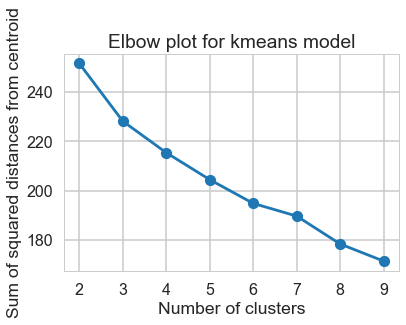

In [34]:
from sklearn import metrics
from scipy.spatial.distance import cdist

SS=[]
K=range(2,10)
for k in K:
    kmeanmodel=KMeans(n_clusters=k)
    kmeanmodel.fit(combined_np)
    SS.append(kmeanmodel.inertia_)

plt.plot(K,SS,'-o')
plt.xticks(K)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances from centroid')
plt.title('Elbow plot for kmeans model')
plt.show()


## From the above plot, it is difficult to determine the best value for k. While there is a small elbow at k=3, the elbow is not sharp enough. This turned out to be my biggest challenge.

## So, I assume that k=3 or k=8 to be the best values of k.

In [163]:
kmeanmodel_3=KMeans(n_clusters=3)
labels_3=pd.DataFrame(kmeanmodel_3.fit_predict(combined_np),columns=['Cluster Label'])
labels_3_1=labels_3.groupby('Cluster Label').size().reset_index(name='counts')
#print(labels_3)


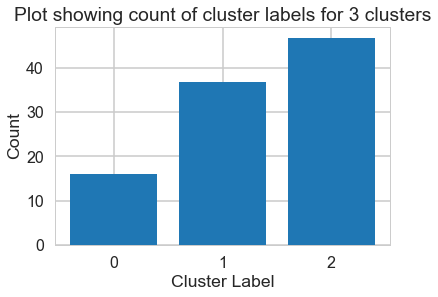

In [87]:
plt.bar(labels_3_1['Cluster Label'],labels_3_1['counts'])
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.title('Plot showing count of cluster labels for 3 clusters')
plt.show()

In [90]:
kmeanmodel_8=KMeans(n_clusters=8)
labels_8=pd.DataFrame(kmeanmodel_8.fit_predict(combined_np),columns=['Cluster Label'])
labels_8_1=labels_8.groupby('Cluster Label').size().reset_index(name='counts')
#print(labels_8_1.info())

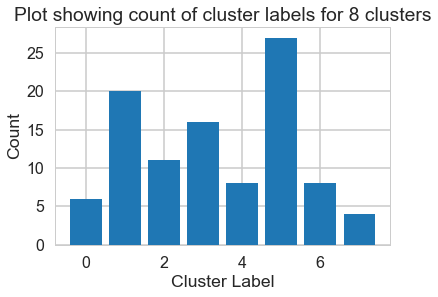

In [91]:
plt.bar(labels_8_1['Cluster Label'],labels_8_1['counts'])
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.title('Plot showing count of cluster labels for 8 clusters')
plt.show()

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [145]:
from sklearn import metrics
silhouette_plot=[]
K=range(2,10)

for k in K:
    kmeanmodel=KMeans(n_clusters=k,random_state=42)
    kmeanmodel_label=kmeanmodel.fit_predict(combined_np)
    silhouette_avg=sklearn.metrics.silhouette_score(combined_np,labels=kmeanmodel_label)
    print("For n_clusters =",k,
          "The average silhouette score is :",silhouette_avg)
    silhouette_plot.append(silhouette_avg)
    

For n_clusters = 2 The average silhouette score is : 0.0917487150875
For n_clusters = 3 The average silhouette score is : 0.115424070379
For n_clusters = 4 The average silhouette score is : 0.0967025836069
For n_clusters = 5 The average silhouette score is : 0.145315688203
For n_clusters = 6 The average silhouette score is : 0.133131266271
For n_clusters = 7 The average silhouette score is : 0.130739507718
For n_clusters = 8 The average silhouette score is : 0.123975729011
For n_clusters = 9 The average silhouette score is : 0.120246511094


In [148]:
silhouette_clusters=pd.Series(np.arange(2,10,1))
silhouette_plot_1=pd.Series(silhouette_plot,index=np.arange(0,8,1))

print(silhouette_clusters)
print(silhouette_plot)

0    2
1    3
2    4
3    5
4    6
5    7
6    8
7    9
dtype: int32
[0.091748715087503513, 0.11542407037894219, 0.096702583606931222, 0.14531568820332333, 0.13313126627114877, 0.13073950771832585, 0.12397572901124844, 0.1202465110942483]


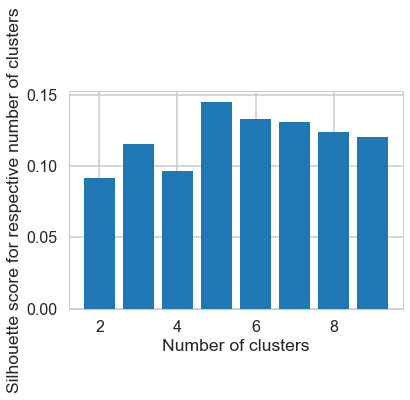

In [157]:
silhouette_combined=pd.DataFrame(data=dict(silhouette_clusters=silhouette_clusters,silhouette_plot=silhouette_plot))

plt.bar(silhouette_clusters,silhouette_plot)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score for respective number of clusters')
plt.show()

## Based on the silhouette score, k=5 is the optimal number of clusters for this problem since the score is highest for k=5. 

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [243]:
#your turn
from sklearn.decomposition import PCA

pca=PCA(n_components=2)

combined_np_pca=pd.DataFrame(pca.fit_transform(combined_np))

combined_4=combined_3.copy()

combined_4.reset_index(inplace=True)

cust_name=combined_4['customer_name']

cust_name_labels=pd.concat([cust_name,labels_3,combined_np_pca],axis=1)

cust_name_labels.columns=['customer_name','cluster_label','X','Y']

print(cust_name_labels)

   customer_name  cluster_label         X         Y
0          Adams              2  1.007580  0.108215
1          Allen              1 -0.287539  0.044715
2       Anderson              0 -0.392032  1.038391
3         Bailey              2  0.699477 -0.022542
4          Baker              1  0.088183 -0.471695
5         Barnes              1 -0.485282 -0.725503
6           Bell              0 -0.591941  1.506500
7        Bennett              2  0.661732  0.090308
8         Brooks              1 -0.118943 -0.577499
9          Brown              2  1.079827 -0.007488
10        Butler              1 -0.240431 -0.617026
11      Campbell              0 -0.522247  1.231406
12        Carter              2  1.260763 -0.014255
13         Clark              1 -0.579221 -0.420475
14       Collins              1  0.193998  0.010306
15          Cook              0 -0.392032  1.038391
16        Cooper              1 -0.406276 -0.045771
17           Cox              0 -0.591941  1.506500
18          

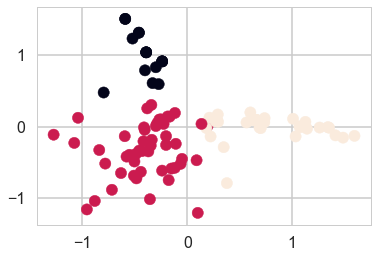

In [211]:
plt.scatter(x='X',y='Y',c='Cluster Label',data=cust_name_labels,alpha=1)
plt.show()

## Based on the plot developed after PCA decomposition, 3 clusters seems to be the best option since the above plot shows 3 distinct sets of data points. So, it can be said that the elbow method works quite well. 

In [249]:
combined_4=combined.copy()

combined_story=pd.merge(combined_4,cust_name_labels,on='customer_name')

#combined_story_campaign=pd.pivot_table(data=combined_story,index=['varietal'],columns='campaign',values='Cluster Label',aggfunc='count')

combined_story_1=combined_story.groupby(['cluster_label','varietal']).size()
print(combined_story_1)

cluster_label  varietal          
0              Champagne              1
               Chardonnay             1
               Malbec                 1
               Merlot                 1
               Pinot Noir            37
               Prosecco               2
1              Cabernet Sauvignon    31
               Champagne             75
               Chardonnay            14
               Espumante              8
               Malbec                15
               Merlot                13
               Pinot Grigio           1
               Pinot Noir             7
               Prosecco              21
2              Cabernet Sauvignon     1
               Champagne              5
               Espumante             32
               Malbec                16
               Merlot                 6
               Pinot Grigio          16
               Prosecco              20
dtype: int64


In [250]:
combined_story_2=combined_story.groupby(['cluster_label','campaign']).size()
print(combined_story_2)

cluster_label  campaign 
0              April         1
               January       7
               July          7
               June          1
               May           1
               October      13
               September    13
1              April        14
               August       28
               December     27
               February     20
               January      13
               July          5
               June         19
               March        17
               May          16
               November      6
               October      16
               September     4
2              April         2
               August        3
               December     16
               February      2
               July         14
               March        34
               May           7
               November     17
               October       1
dtype: int64


In [251]:
combined_story_3=combined_story.groupby(['cluster_label','origin']).size()
print(combined_story_3)

cluster_label  origin      
0              Australia       13
               California       2
               France           7
               Germany          7
               Italy           12
               New Zealand      1
               South Africa     1
1              Australia        9
               California      10
               Chile           30
               France          87
               Germany          8
               Italy           12
               New Zealand     11
               Oregon          11
               South Africa     7
2              Australia       17
               California       4
               Chile            7
               France          34
               Germany          1
               New Zealand      1
               Oregon          15
               South Africa    17
dtype: int64


## As shown in combined_story_1 and 3, varietal and origin can be clearly segmented using cluster_label. For instance, cluster_label 1 is composed 50% of French wines. Similarly, of the 81 transactions of Champagne variety of wines, 76 of them fall in cluster_label 1. So, it can be concluded that cluster labels have been developed based on customer preference of wine variety and origin. 

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

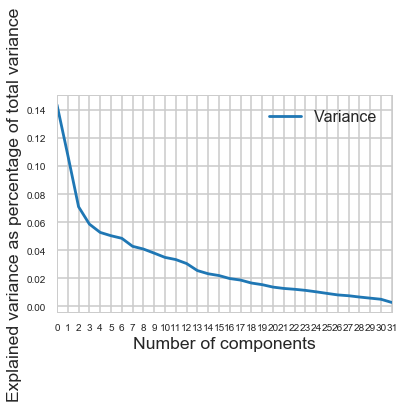

In [273]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(combined_np)

# Do the rest on your own :)
#print(pca.explained_variance_ratio_)

explained_variance_ratio=pd.DataFrame(pca.explained_variance_ratio_,columns=['Variance'])

explained_variance_ratio.plot()
plt.xticks(np.arange(0,32),fontsize=10)
plt.yticks(np.arange(0,0.15,0.02),fontsize=10)
plt.xlabel('Number of components')
plt.ylabel('Explained variance as percentage of total variance')
plt.show()

## Based on the above curve, we can say that 4 principal components account for 40% of the datasets total variance. We can see a clear elbow at x=3, which is the 4th component. So, the number of optimal dimensions equals 4.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [288]:
# Your turn
import sklearn.cluster
    
ap=sklearn.cluster.AffinityPropagation().fit(combined_np)

ap_cluster_center_indices=ap.cluster_centers_indices_

ap_labels=ap.labels_

ap_n_clusters=len(ap_cluster_center_indices)

print("Number of clusters as per affinity propogation",ap_n_clusters)

print("Silhouette score for affinity propogation",sklearn.metrics.silhouette_score(combined_np,ap_labels))


Number of clusters as per affinity propogation 14
Silhouette score for affinity propogation 0.123465236045


In [297]:
K=range(2,10)

for k in K:
    sc=sklearn.cluster.SpectralClustering(n_clusters=k,random_state=42).fit(combined_np)
    sc_labels=sc.labels_
    sc_silhouette_avg=sklearn.metrics.silhouette_score(combined_np,labels=sc_labels)
    print("For n_clusters =",k,
          "The average silhouette score for spectral clustering is :",sc_silhouette_avg)


For n_clusters = 2 The average silhouette score for spectral clustering is : 0.0591405970172
For n_clusters = 3 The average silhouette score for spectral clustering is : 0.0999059123102
For n_clusters = 4 The average silhouette score for spectral clustering is : 0.0290656989328
For n_clusters = 5 The average silhouette score for spectral clustering is : 0.0158567687769
For n_clusters = 6 The average silhouette score for spectral clustering is : 0.0175964169953
For n_clusters = 7 The average silhouette score for spectral clustering is : 0.0479193535046
For n_clusters = 8 The average silhouette score for spectral clustering is : 0.0526822430984
For n_clusters = 9 The average silhouette score for spectral clustering is : 0.0304730322858


In [300]:
K=range(2,10)

for k in K:
    ac=sklearn.cluster.AgglomerativeClustering(n_clusters=k).fit(combined_np)
    ac_labels=ac.labels_
    ac_silhouette_avg=sklearn.metrics.silhouette_score(combined_np,labels=ac_labels)
    print("For n_clusters =",k,
          "The average silhouette score for agglomerative clustering is :",ac_silhouette_avg)


For n_clusters = 2 The average silhouette score for agglomerative clustering is : 0.0825801782318
For n_clusters = 3 The average silhouette score for agglomerative clustering is : 0.116258788636
For n_clusters = 4 The average silhouette score for agglomerative clustering is : 0.128937578159
For n_clusters = 5 The average silhouette score for agglomerative clustering is : 0.140897399708
For n_clusters = 6 The average silhouette score for agglomerative clustering is : 0.147152172046
For n_clusters = 7 The average silhouette score for agglomerative clustering is : 0.152751527511
For n_clusters = 8 The average silhouette score for agglomerative clustering is : 0.155780537186
For n_clusters = 9 The average silhouette score for agglomerative clustering is : 0.12075124132


## Agglomerative clustering with 8 clusters does the best since it has the highest silhouette score. Spectral clustering does the worst as seen from the very low silhouette scores. Affinity propagation is mediocre. 